Chapter04
===
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")

from IPython.core.pylabtools import figsize

## 4.4. 単回帰
- X: 年齢
- Y: 年収

In [2]:
df = pd.read_csv("./input/data-salary.txt")
df.tail()

,X,Y
15,56,1007
16,57,1233
17,58,1202
18,59,1123
19,59,1314


### 4.4.2. データの分布の確認

Text(0,0.5,'Y')

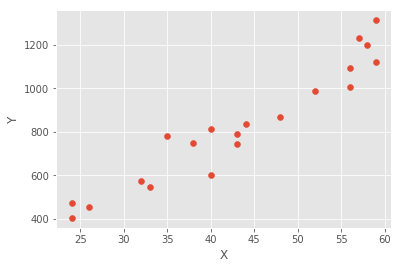

In [3]:
plt.scatter(df.X, df.Y)
plt.xlabel("X")
plt.ylabel("Y")

### 4.4.4. Rのlm関数で推定
Pythonなので、代わりにscikit-learnで直線をあてはめる

信頼区間はこのモデルでは得られないので省略

In [4]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(df.X.values[:, np.newaxis], df.Y)
print("傾き: {}, 切片: {}".format(model.coef_[0], model.intercept_))

傾き: 21.904201433018358, 切片: -119.69713212134582


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### 4.4.5. Stanで実装
参考: http://statmodeling.hatenablog.com/entry/pystan-rstanbook-chap5-1

モデルは`str`で与えても良いが、`pystan.StanModel`でパスを指定すれば外部のモデルファイルを利用できる。

In [5]:
!cat ./model/model4-5.stan

data {
  int N;
  real X[N];
  real Y[N];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N) {
    Y[n] ~ normal(a + b*X[n], sigma);
  }
}


In [6]:
# StanModelに渡すデータは、モデル内での変数名に値を対応づけたdictとして用意する
# pandasのDataFrameの場合、以下のようにすると便利
data = {
    **df.to_dict("list"),
    "N": len(df)
}

print(data)

{'X': [24, 24, 26, 32, 33, 35, 38, 40, 40, 43, 43, 44, 48, 52, 56, 56, 57, 58, 59, 59], 'Y': [472, 403, 454, 575, 546, 781, 750, 601, 814, 792, 745, 837, 868, 988, 1092, 1007, 1233, 1202, 1123, 1314], 'N': 20}


In [7]:
# モデルは外部ファイルを指定
sm = pystan.StanModel(file="./model/model4-5.stan")
# default設定でMCMCサンプリングを実行
# n_jobs=-1でCPUを全て使うがデフォルトでそうなってるらしい
fit = sm.sampling(data=data, seed=1234, n_jobs=-1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a5383320e5d818d976e59523c8e84c3c NOW.


In [8]:
# 概要を確認
print(fit)

Inference for Stan model: anon_model_a5383320e5d818d976e59523c8e84c3c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -122.1    2.32  76.05 -277.1 -171.1 -121.3 -72.33  25.91   1079    1.0
b      21.97    0.05    1.7  18.63  20.84  21.95  23.03  25.41   1055    1.0
sigma  85.38    0.46  15.97   61.1  74.03  83.61   93.7 121.65   1185    1.0
lp__  -93.67    0.04   1.37 -97.08 -94.27 -93.33 -92.71 -92.17    942   1.01

Samples were drawn using NUTS at Wed May  1 13:27:51 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


**a, bのmean（事後平均）がscikit-learnの単回帰での係数とほぼ同じになっていることに注目!**

なお、`n_eff`はStanが自己相関などから判断した実行的なMCMCサンプル数で、少なくとも100ぐらいあることが望ましいらしい

`se_mean`はmeanの標準誤差で、MCMCサンプルの分散を`n_eff`で割ったもの

`Rhat`はMCMCが収束したかを示す指標。本書では、chain数が3以上で、全てのパラメータで Rhat < 1.1 なら収束したとみなす。

`chains`は最低3, 4が推奨らしい

`iter`は500-1000ぐらいで試行錯誤し、モデルが決まったら1000-500ぐらいまで大きくする。

`warmup`はtrace plotを見れば良い。だいたい100-500ぐらいあれば十分

`thin`はStanではサンプル列の自己相関が低いので1でだいたいOKだが、trace plotの形状によっては改善の余地がある。

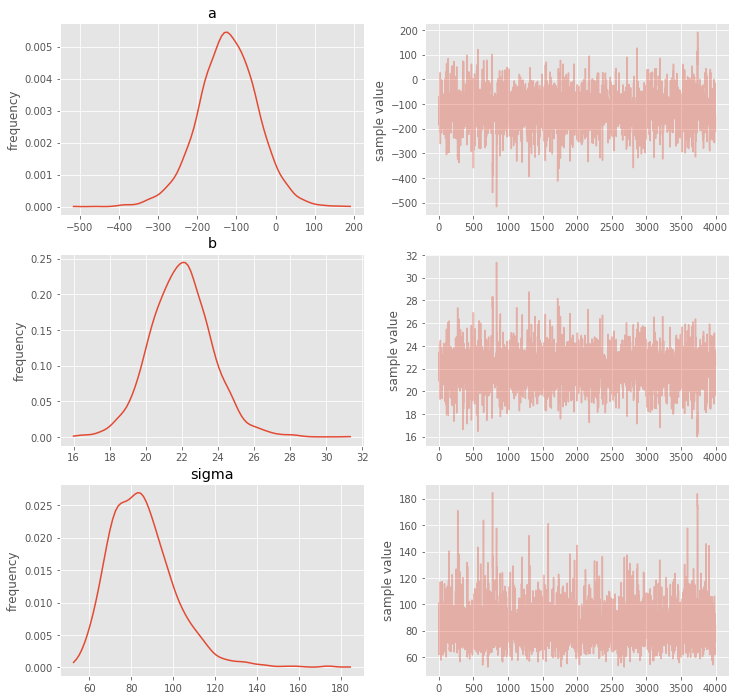

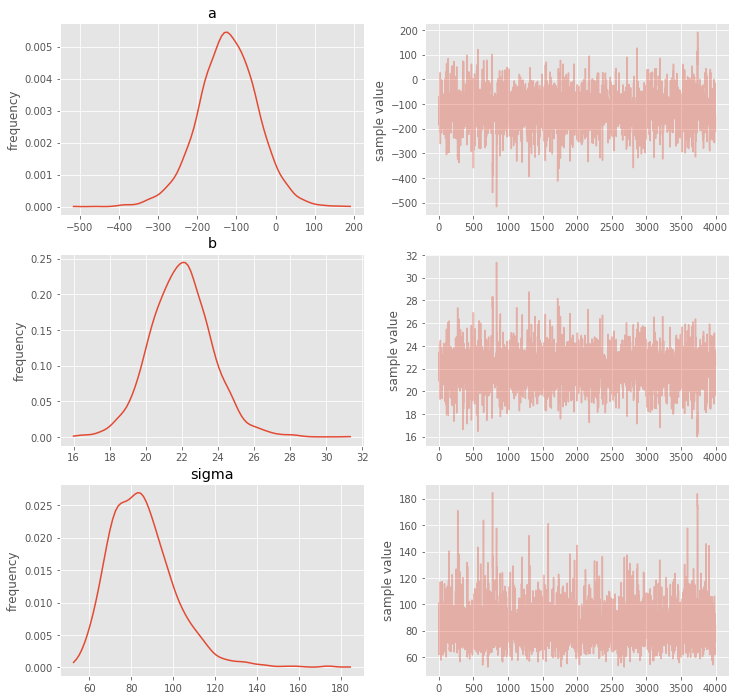

In [9]:
figsize(12, 12)

# 以下のようにするとparameterごとの分布とtrace plotが確認できる
fit.plot()

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


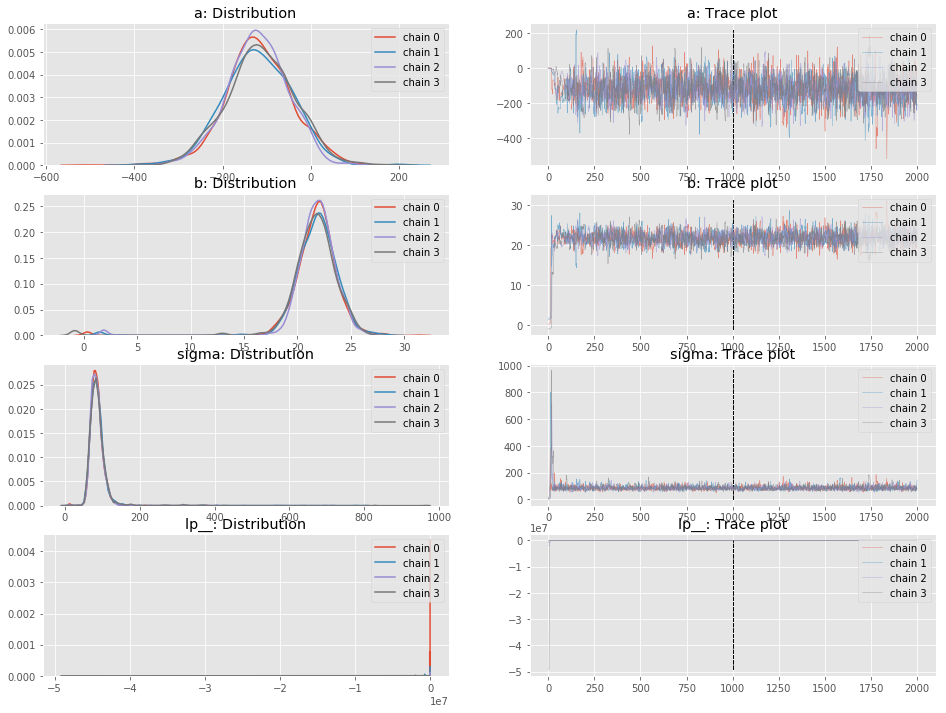

In [10]:
# 微妙なので手動でplot
figsize(16, 12)

# shape (<# iter (including warmup)>, <# chain>, <# param + 1(lp__)>)
mcmc_sample = fit.extract(permuted=False, inc_warmup=True)
n_param = mcmc_sample.shape[2]
n_chain = mcmc_sample.shape[1]
params = fit.model_pars + ["lp__"]
warmup = fit.sim["warmup"]

fig, axes = plt.subplots(n_param, 2)
for i_param in range(n_param):
    for i_chain in range(n_chain):
        # KDE plot (Posterioer istribution)
        axes[i_param, 0].set_title("{}: Distribution".format(params[i_param]))
        sns.kdeplot(mcmc_sample[:, i_chain, i_param], ax=axes[i_param, 0], label="chain {}".format(i_chain))
        axes[i_param, 0].legend(loc="upper right")

        # Trace plot (Chain)
        axes[i_param, 1].set_title("{}: Trace plot".format(params[i_param]))
        axes[i_param, 1].plot(mcmc_sample[:, i_chain, i_param], alpha=0.6, lw=0.5, label="chain {}".format(i_chain))
        axes[i_param, 1].vlines(warmup, mcmc_sample[:, :, i_param].min(), mcmc_sample[:, :, i_param].max(), linestyle="dashed", lw=1)
        axes[i_param, 1].legend(loc="upper right")

### 4.4.11 ベイズ信頼区間とベイズ予測区間の算出

In [11]:
# sampleはextract()でparameterごとに取り出せる
# 下記の取り出し方をした場合、warmupは除かれて全てのchainが結合された状態になっているっぽい
fit.extract()

OrderedDict([('a',
              array([-197.77440235,  -53.10440643, -144.0701811 , ..., -323.51073982,
                     -234.64414713,  -78.60509874])),
             ('b',
              array([22.53984079, 20.90029508, 22.65538771, ..., 26.42758866,
                     23.60357406, 20.07393409])),
             ('sigma',
              array([86.12360464, 62.07723323, 67.01992207, ..., 74.19581998,
                     88.05799155, 81.43803333])),
             ('lp__',
              array([-95.7668283 , -94.78802597, -92.75118664, ..., -97.20937106,
                     -95.04672033, -94.97900935]))])

In [12]:
# 傾きbの95%ベイズ信頼区間
confidence_interval = np.quantile(fit.extract()["b"], [0.025, 0.975])
print("傾きbの95%ベイズ信頼区間: {:.2f} - {:.2f}".format(*confidence_interval))

傾きbの95%ベイズ信頼区間: 18.63 - 25.40


#### parameterの事後分布の同時分布をplot

In [13]:
fit.model_pars

['a', 'b', 'sigma']

In [14]:
# fit.to_dataframe() はpandasのversionの関係? でTypeErrorになるので、手動でやる
df_posterior = pd.DataFrame()
for p in fit.model_pars:
    df_posterior[p] = fit.extract()[p]
df_posterior.tail()

,a,b,sigma
3995,-67.005836,20.381465,75.516083
3996,-139.718997,22.214122,71.598119
3997,-323.510740,26.427589,74.195820
3998,-234.644147,23.603574,88.057992
3999,-78.605099,20.073934,81.438033


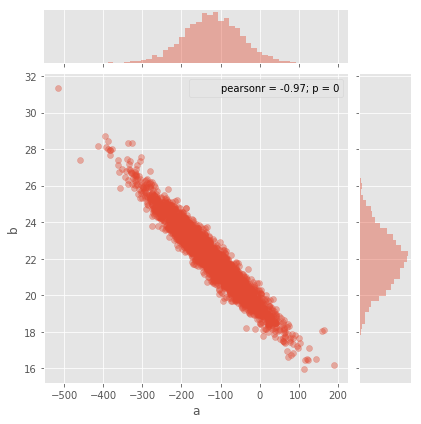

In [15]:
sns.jointplot(df_posterior.a, df_posterior.b, alpha=0.4)

#### 予測分布
「基本年収の分布」と「年収の予測分布」それぞれを区別してMCMCサンプルから描画していることに注意。

基本年収: 入力Xとparameterから決定論的に線形な式で定まる予測値。parameter自体が分布をもつ（事後分布）ので幅をもつ。

=> さらに、sigmaによって生じるばらつきも考慮すると「年収の予測分布」となる

In [16]:
# 1. 基本年収のベイズ信頼区間

# df_posteriorにサンプルを収めた状態になっている
N_mcmc = len(df_posterior)

ages = np.arange(23, 60+1)
# 23 - 60の各ageについて、MCMCサンプルそれぞれのパラメータにおけるageの基本年収を算出
df_base = pd.DataFrame(columns=["lower", "median", "upper"])
for age in ages:
    df_base = df_base.append(pd.Series(np.quantile(df_posterior.a +df_posterior.b*age, [0.025, 0.5, 0.975]), index=df_base.columns, name=age))

In [17]:
df_base.head()

,lower,median,upper
23,301.991247,383.580648,460.762536
24,327.000025,405.664858,479.760360
25,352.035720,427.728170,498.603061
26,376.887630,449.463839,518.201756
27,402.277827,471.483981,537.315677


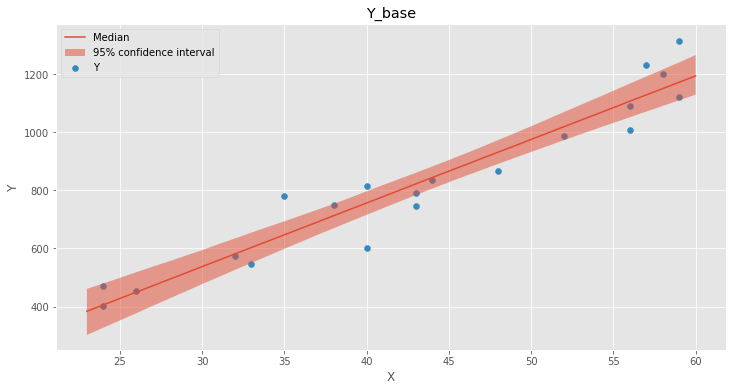

In [29]:
figsize(12, 6)
plt.figure()
plt.plot(ages, df_base["median"].values, label="Median")
plt.fill(
    np.concatenate([ages, ages[::-1]]),
    np.concatenate([df_base.lower, df_base.upper[::-1]]),
    alpha=0.5, ec="None", label="95% confidence interval"
)

plt.scatter(df.X, df.Y)

plt.title("Y_base")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='upper left')

In [30]:
# 2. ベイズ予測区間

# df_posteriorにサンプルを収めた状態になっている
N_mcmc = len(df_posterior)

ages = np.arange(23, 60+1)
# 23 - 60の各ageについて、MCMCサンプルそれぞれのパラメータにおけるageの基本年収を算出
df_pred = pd.DataFrame(columns=["lower2.5", "lower25", "median", "upper75", "upper97.5"])
for age in ages:
    df_pred = df_pred.append(pd.Series(
        np.quantile(
            np.random.normal(
                loc=df_posterior.a + df_posterior.b*age,
                scale=df_posterior.sigma
            ),
            [0.025, 0.25, 0.5, 0.75, 0.975]
        ),
        index=df_pred.columns,
        name=age
    ))

In [31]:
df_pred.head()

,lower2.5,lower25,median,upper75,upper97.5
23,196.233062,323.113958,385.837936,447.427001,566.827623
24,214.101451,344.183440,407.353723,470.126799,597.023301
25,237.420079,367.740899,427.651099,488.324722,601.089302
26,260.556821,389.132937,451.075397,511.304115,642.802678
27,282.377360,408.866813,470.050147,529.971394,650.641944


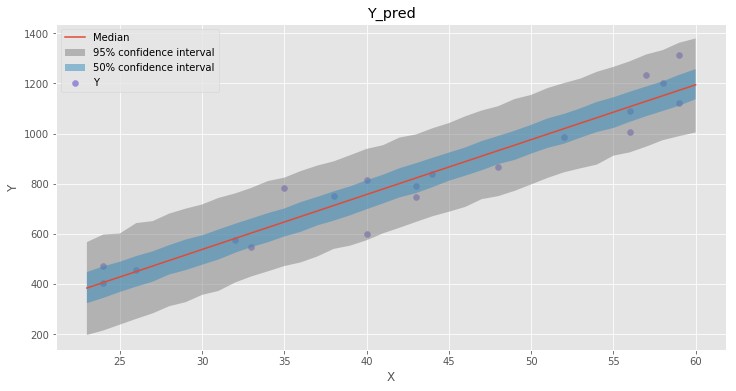

In [33]:
figsize(12, 6)
plt.figure()
plt.plot(ages, df_base["median"], label="Median")
plt.fill(
    np.concatenate([ages, ages[::-1]]),
    np.concatenate([df_pred["lower2.5"], df_pred["upper97.5"][::-1]]),
    alpha=0.5, ec="None", label="95% confidence interval", fc="gray"
)
plt.fill(
    np.concatenate([ages, ages[::-1]]),
    np.concatenate([df_pred["lower25"], df_pred["upper75"][::-1]]),
    alpha=0.5, ec="None", label="50% confidence interval",
)

plt.scatter(df.X, df.Y)

plt.title("Y_pred")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='upper left')

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


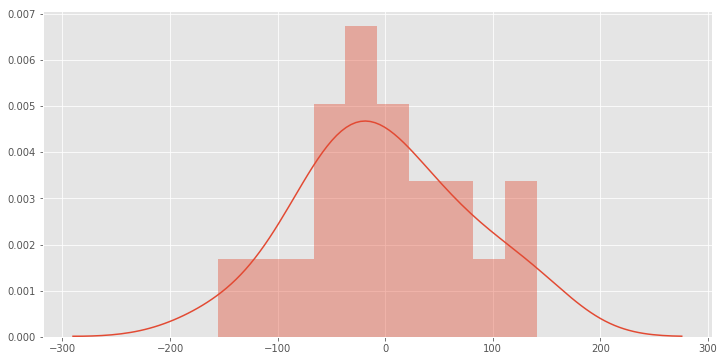

In [34]:
# ついでに残差が正規分布に従ってそうか確認
errors = [row.Y - df_base.loc[row.X]["median"] for _, row in df.iterrows()]

sns.distplot(errors, bins=10)

### 4.4.12. transformed parametersブロックとgenerated quantitiesブロック
MCMCサンプルからPythonで計算する代わりに、あらかじめサンプルから決定論的に定まる量も計算させてしまうことができる

- transformed parameters: data, parametersブロックで宣言されたものから新たにサンプリングしたい変数を作れる。
    - 新しいパラメータ変数を作る場合にも使うらしい。modelのブロックで分布を記述する際、transformed parameterを使うことができる。
- generated quantities: ここで乱数を発生させて予測分布のための予測サンプルを全ての年齢ごとに生成

この場合は、今までPythonを使って23-60歳それぞれの基本年収y_baseやsigmaを考慮してサンプリングされた予測分布をStan側にサンプリングさせることが可能になる。ただし、23-60までの配列とその長さはPythonからStanに渡す必要が生じる。

stanの記述としてはあくまでもサンプルひとつひとつについての関係式を`=`で定義してやればOK

In [35]:
# 改良版の.stanファイル
!cat ./model/model4-4.stan

data {
  int N;
  real X[N];
  real Y[N];
  int N_new;
  real X_new[N_new];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

transformed parameters {
  // dataとparameterの内容から、新たにサンプリングする変数を作る
  real y_base[N];
  for (n in 1:N)
    y_base[n] = a + b*X[n]; // 1行なので{}は省略できる
}

model {
  for (n in 1:N)
    Y[n] ~ normal(y_base[n], sigma);
}

generated quantities {
  // data, parameters, transformed parametersで宣言された量から新たにサンプリングする変数を作る
  real y_base_new[N_new];
  real y_new[N_new];
  for (n in 1:N_new) {
    y_base_new[n] = a + b*X_new[n];
    y_new[n] = normal_rng(y_base_new[n], sigma); # ~は使えないので*_rngで乱数を生成
  }
}


In [36]:
# 同内容で実行
ages = np.arange(23, 60+1)

# X_new, N_newも渡す
data = {
    **df.to_dict("list"),
    "N": len(df),
    "X_new": ages.tolist(),
    "N_new": len(ages)
}

# モデルは外部ファイルを指定
sm = pystan.StanModel(file="./model/model4-4.stan")
# default設定でMCMCサンプリングを実行
fit = sm.sampling(data=data, seed=1234)
# fit.extract()をすると、y_baseなどが確かにサンプリングされているはず

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0ed8faeb1a957a490073ce328e27977c NOW.


#### 今までの描画処理を関数にして、改良版で確かめる

In [37]:
fit.extract()["y_base_new"].shape

(4000, 38)

In [38]:
def draw_interval(samples, x_list, quantiles=[0.025, 0.975]):
    """ y_baseのベイズ信頼区間を描画 """
    figsize(12, 6)
    plt.figure()
    plt.plot(x_list, np.quantile(samples, [0.5], axis=0).ravel(), label="Median")
    q = np.quantile(samples, quantiles, axis=0)
    plt.fill(
        np.concatenate([x_list, x_list[::-1]]),
        np.concatenate([q[0], q[1][::-1]]),
        alpha=0.5, ec="None", label="95% confidence interval"
    )

#    plt.scatter(df.X, df.Y)

    plt.title("Y_base")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc='upper left')

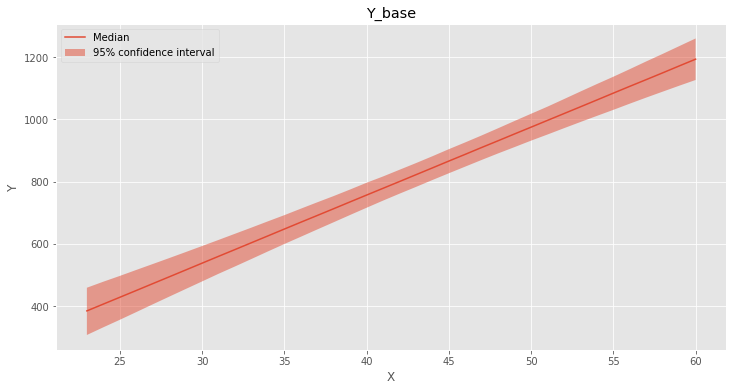

In [39]:
draw_interval(fit.extract()["y_base_new"], ages)

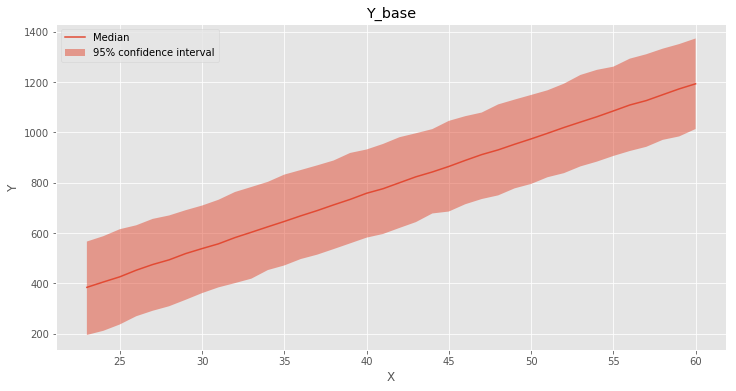

In [40]:
draw_interval(fit.extract()["y_new"], ages)

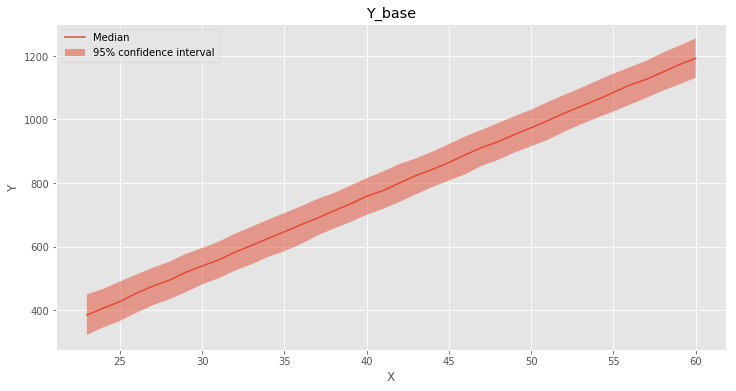

In [41]:
draw_interval(fit.extract()["y_new"], ages, quantiles=[0.25, 0.75])